# Financial News Headline Sentiment Classifier


**Motivation**
Market sentiment derived from news articles is one factor that can influence trading and investment decisions. By understanding the sentiment of financial news headlines, investors, traders, and financial institutions have another tool that they can use to make more informed decisions, assess risks, and potentially even design algorithmic trading strategies. This notebook demonstrates the process of training a BERT (Bidirectional Encoder Representations from Transformers) model on the financial_phrasebank dataset that will be used to classify Marketwatch.com headlines into three sentiment categories: positive, neutral, and negative. While this exercise uses financial headlines as an input, the underlying techniques used in this notebook can be transferred to simmilar text classification tasks.
The methods outlined in this notebook also serve as a less-complicated, indirect sample for my actual data science work making a similar transformer model for multilabel text classification.

**Data Source**
The financial_phrasebank dataset is a collection of financial news headlines for companies listed in OMX Helsinki, each labeled with a sentiment score of 2 for positive, 1 for neutral, or 0 for negative. Labels were decided upon by a group of 13 annotators at the  Aalto University School of Business in which 75% of the judges agree.

In [1]:
import os 
import gc
import numpy as np
import pandas as pd
import pyodbc as pb
from tqdm.notebook import tqdm
from sklearn.model_selection import StratifiedShuffleSplit
from transformers import AutoTokenizer
import heapq
import torch
import matplotlib.pyplot as plt
from datasets import Dataset
from transformers import (BertForSequenceClassification, 
                          AdamW, 
                          BertConfig,
                          AutoModel, 
                          AutoModelForSequenceClassification,
                          BitsAndBytesConfig, 
                          AutoModelForCausalLM,
                          TrainingArguments, 
                          Trainer, 
                          EarlyStoppingCallback)
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
import multiprocessing as mp
from accelerate import FullyShardedDataParallelPlugin, Accelerator
from torch.distributed.fsdp.fully_sharded_data_parallel import FullOptimStateDictConfig, FullStateDictConfig
from peft import (LoraConfig,
                  LoraModel,
                  get_peft_model,)
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts
import bitsandbytes as bnb
from bitsandbytes.optim import AdamW8bit
from torch import nn
from transformers.trainer_pt_utils import get_parameter_names



In [2]:
# Show all dataframe columns
pd.set_option('display.max_columns', None)

In [3]:
from datasets import load_dataset, concatenate_datasets

# Load the datasets into a pandas dataframe
headlines = pd.DataFrame( load_dataset("financial_phrasebank", "sentences_75agree",trust_remote_code=True)["train"] )

In [4]:
headlines.head()

,sentence,label
0,"According to Gran , the company has no plans t...",1
1,With the new production plant the company woul...,2
2,"For the last quarter of 2010 , Componenta 's n...",2
3,"In the third quarter of 2010 , net sales incre...",2
4,Operating profit rose to EUR 13.1 mn from EUR ...,2


In [5]:
headlines.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3453 entries, 0 to 3452
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   sentence  3453 non-null   object
 1   label     3453 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 54.1+ KB


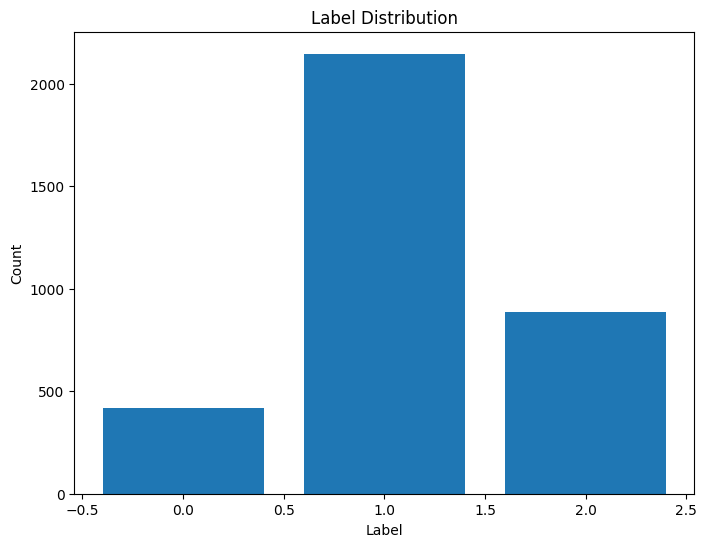

In [6]:
# Count the occurrences of each label
label_counts = headlines['label'].value_counts()

# Create a bar plot of the label distribution
plt.figure(figsize=(8, 6))
plt.bar(label_counts.index, label_counts.values)
plt.xlabel('Label')
plt.ylabel('Count')
plt.title('Label Distribution')
plt.show()

# Cleaning?

Less is more when training a transformer model, such as RoBERTa, for text classification. The basic concept behind transformers is to learn optimal representations of language by understanding the contexts, nuances, and intricacies present in the text. This is achieved by representing text as a sequence of tokens and using an attention mechanism to learn the effect of each token on the others in the sequence. Training the model on unprocessed text preserves the semantic richness of the language, which would otherwise be parsed out through the removal of special characters and stop words, stemming, lemmatization, etc. While text cleaning is warranted for simpler models that benefit from uniformity, dimensionality reduction, and noise removal, (see Tf-IDF, count vectorization, etc.) opting out of text processing is advantageous here since the news headlines are short enough to meet the 512-token input limit

# Check: Do our Inputs Meet the 512 Token Limit?

In [7]:
# What are the indices of the 10 longest notes?
# These are the longest character lengths, not necessarily the longest token lengths
ten_longest_inputs_idx = headlines['sentence'].apply(lambda x: len(x)).sort_values(ascending=False).index[:50]

ten_longest_inputs_idx

Index([1222, 1654,  729, 2139, 2996,  319, 2708, 3280, 2196, 1903,  975, 2195,
       2733, 1871, 1528, 1699, 3201,  959,  958,  850,   48, 1525, 2119, 1653,
       1242,  677,  621,  722,  359, 1232, 1083,  330, 2056, 2130,   59,  905,
       1077, 3222, 1828, 1876, 1385, 1387, 3202, 1633, 2762,  114, 1199, 3197,
         60, 3436],
      dtype='int64')

In [8]:
# Let's check how many tokens these are... Might not need all 512 tokens
ten_longest_inputs = headlines['sentence'].iloc[ten_longest_inputs_idx].values


In [9]:
print('Loading tokenizer')
tokenizer = AutoTokenizer.from_pretrained("soleimanian/financial-roberta-large-sentiment")

Loading tokenizer


In [10]:
token_lengths = []
max_tokens = 0
for input in ten_longest_inputs:
    encodings = tokenizer(input,
                            add_special_tokens=True, # Add '[CLS]' and '[SEP]'
                            max_length=512,
                            truncation=True,
                            padding='do_not_pad')
    input_ids = encodings.input_ids
    max_tokens = max(max_tokens, len(input_ids))

print(f'The longest sequence is {max_tokens} tokens')

The longest sequence is 133 tokens


# Labels

In [11]:
label2id = {'Positive': 2,
            'Neutral': 1,
            'Negative': 0
            }
id2label = {0: 'Negative',
            1:'Neutral',
            2: 'Positive'}
    
label2id

{'Positive': 2, 'Neutral': 1, 'Negative': 0}

In [12]:
id2label

{0: 'Negative', 1: 'Neutral', 2: 'Positive'}

In [13]:
headlines.head()

,sentence,label
0,"According to Gran , the company has no plans t...",1
1,With the new production plant the company woul...,2
2,"For the last quarter of 2010 , Componenta 's n...",2
3,"In the third quarter of 2010 , net sales incre...",2
4,Operating profit rose to EUR 13.1 mn from EUR ...,2


# Make Train/Test Splits

Use Stratified Shuffle Split to ensure equal class distribution among splits

In [14]:
X = headlines[['sentence']].values
y= headlines.label.values


In [15]:
# Define the split sizes
split_sizes = [0.8, 0.1, 0.1]

In [16]:
# Define the splitter with 2 splits
splitter = StratifiedShuffleSplit(n_splits=2, test_size=split_sizes[-1], random_state=42)

In [17]:
# Split the data into a train-dev set and a test set
train_dev_indices, test_indices = next(splitter.split(X, y))

In [18]:
# Get the train-dev data and the test data
X_train_dev, y_train_dev = X[train_dev_indices], y[train_dev_indices]
X_test, y_test = X[test_indices], y[test_indices]

In [19]:
# Define the sizes of the train and dev sets
train_size = int(split_sizes[0] * len(X_train_dev))
dev_size = int(split_sizes[1] * len(X))

In [20]:
# Split the train-dev set into a train set and a dev set
splitter = StratifiedShuffleSplit(n_splits=1, test_size=dev_size, random_state=42)
train_indices, dev_indices = next(splitter.split(X_train_dev, y_train_dev))

In [21]:
# Get the train data and the dev data
X_train, y_train = X_train_dev[train_indices], y_train_dev[train_indices]
X_dev, y_dev = X_train_dev[dev_indices], y_train_dev[dev_indices]

In [22]:
X_train

array([['Profit for the period was EUR 10.9 mn , down from EUR 14.3 mn in 2009 .'],
       ['Neste Shipping is the most likely to remain Finnish as the oil sector and its transports are significant for emergency supply .'],
       ['Finnish lifting equipment maker Konecranes Oyj said on July 30 , 2008 that its net profit rose to 71.2 mln euro ( $ 111.1 mln ) for the first half of 2008 from 57.1 mln euro ( $ 89.1 mln ) for the same period of 2007 .'],
       ...,
       ['Deliveries will start in the second half of 2007 and the start-up of the mill is scheduled for 2008 .'],
       ["Founded in 1923 , Finnair is one of the world 's oldest airlines and flies to 60 destinations with a fleet of 63 aircraft , employing 9,500 people ."],
       ['Country : ; Germany Sector : Construction-Real Estate ; Machinery-Engineering Target : Caverion GmbH Buyer : YIT Oyj Deal size in USD : 90.3 m Type : Corporate acquisition Status : Agreed']],
      dtype=object)

In [23]:
X_train.shape

(2762, 1)

In [24]:
X_dev.shape

(345, 1)

In [25]:
X_test.shape

(346, 1)

In [26]:
# Get the lists of sentences and their labels.
train_sentences = [narr[0] for narr in X_train] 
train_labels = y_train
dev_sentences = [narr[0] for narr in X_dev]
dev_labels = y_dev
test_sentences = [narr[0] for narr in X_test]
test_labels = y_test

# Tokenization

Tokenization abstracts the news headlines into a structured form that RoBERTa can interpret. This involves breaking the text into smaller units, inserting [CLS] and [SEP] tokens to mark the beginning and end of sentences, padding shorter inputs with [PAD] tokens to a uniform length (133 length as discovered earlier), and truncating longer ones. Attention masks are also created to distinguish between actual inputs and padding. The breakdown and structuring of text in this manner enable the model to effectively understand unseen words, allocate attention appropriately, and capture the contextual relationships within the text, allowing it to make more accurate predictions.

In [27]:
def get_encodings(sentences):

    sentence_dataset = Dataset.from_dict({'sentences':sentences } )
    encodings = sentence_dataset.map(lambda x: tokenizer(
                                                                x['sentences'], 
                                                                add_special_tokens=True, # Add '[CLS]' and '[SEP]'
                                                                max_length=max_tokens, # Replace this part with max_tokens for BigBird
                                                                truncation=True,
                                                                padding='max_length',
                                                                ),
                                            batched=True,
                                            )

    return encodings 

In [28]:
train_encodings = get_encodings(train_sentences)

Map:   0%|          | 0/2762 [00:00<?, ? examples/s]

In [29]:
train_inputs = train_encodings[:]['input_ids']
train_attention = train_encodings[:]['attention_mask']

In [30]:
dev_encodings = get_encodings(dev_sentences)

Map:   0%|          | 0/345 [00:00<?, ? examples/s]

In [31]:
dev_inputs = dev_encodings[:]['input_ids']
dev_attention = dev_encodings[:]['attention_mask']

In [32]:
test_encodings = get_encodings(test_sentences)

Map:   0%|          | 0/346 [00:00<?, ? examples/s]

In [33]:
test_inputs = test_encodings[:]['input_ids']
test_attention = test_encodings[:]['attention_mask']

In [34]:
# Convert all inputs and labels into torch tensors, the required datatype 
# for our model
#Inputs
train_inputs = torch.tensor(train_inputs, dtype=torch.int32)
dev_inputs = torch.tensor(dev_inputs, dtype=torch.int32)
test_inputs = torch.tensor(test_inputs, dtype=torch.int32)


In [35]:
#Labels
train_labels = torch.tensor(train_labels, dtype=torch.long)
dev_labels = torch.tensor(dev_labels, dtype=torch.long)
test_labels = torch.tensor(test_labels, dtype=torch.long)

In [36]:
#Masks
train_masks = torch.tensor(train_attention, dtype=torch.int32)
dev_masks = torch.tensor(dev_attention, dtype=torch.int32)
test_masks = torch.tensor(test_attention, dtype=torch.int32)

In [37]:
# Load the input ids, masks, etc. into separate datasets

train_dataset = Dataset.from_dict({'input_ids':train_inputs,
                                    'attention_mask': train_masks,
                                    'labels': train_labels})

In [38]:
dev_dataset =  Dataset.from_dict({'input_ids': dev_inputs,
                                 'attention_mask': dev_masks,
                                 'labels':dev_labels})

In [39]:
test_dataset =  Dataset.from_dict({'input_ids':test_inputs,
                                    'attention_mask':test_masks,
                                    'labels':test_labels})

# RoBERTa (Robustly Optimized BERT Approach)

RoBERTa was chosen for this project to harness its advanced contextual understanding and exceptional performance in text classification tasks. RoBERTa is a high-performing transformer model developed by Facebook AI, excelling in numerous NLP tasks by leveraging attention mechanisms to understand the intricacies of language. Attention mechanisms enable the model to process and interpret the contextual relations and nuances between different parts of the input text. RoBERTa surpasses its predecessor, BERT, by using refined training techniques, larger datasets, and architectural improvements, which include the elimination of BERT's Next Sentence Prediction objective and dynamic adjustment of input token masking. This optimized training and enhanced contextual understanding make RoBERTa an excellent choice for this text classsification task. 

## Leveraging a Pre-Trained Model for Transfer Learning?

Financial RoBERTa provides an opportunity for transfer learning, as it already acquired acquired an understanding of financial texts through fine-tuning on extensive financial documents like 10Ks and earnings call transcripts (important to note not the dataset used for this task). Using this specialized, pre-trained model facilitates more powerful predictions by effectively increasing the knowledge base of the text documents the model has to learn a language representation from.

In [40]:
bnb_config = BitsAndBytesConfig(
    load_in_8bit=True,
    bnb_4bit_compute_dtype=torch.float16,
    bnb_4bit_quant_type='nf4',
    bnb_4bit_use_double_quant=True
)

In [41]:
model = AutoModelForSequenceClassification.from_pretrained(
    "soleimanian/financial-roberta-large-sentiment", 
    num_labels = len(label2id),
    # attention_probs_dropout_prob=0.1,
    id2label=id2label,
    label2id=label2id,
    device_map='auto'
    )


In [42]:
print(model.get_memory_footprint())

1421459500


In [43]:
model

RobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 1024, padding_idx=1)
      (position_embeddings): Embedding(514, 1024, padding_idx=1)
      (token_type_embeddings): Embedding(1, 1024)
      (LayerNorm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-23): 24 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=1024, out_features=1024, bias=True)
              (key): Linear(in_features=1024, out_features=1024, bias=True)
              (value): Linear(in_features=1024, out_features=1024, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=1024, out_features=1024, bias=True)
 

# Evaluation Metrics: Accuracy, Macro/Weighted F1, Precision, Recall

In [44]:
# Function to calculate the accuracy and other metrics of our predictions vs labels
def compute_metrics_multiclass(eval_pred):
    # Labels give the ground truth for each *sentence* (num_classes, 1)
    # Preds give the unnormalized probabilities for each class in a sentence (num_sentences, num_classes)
    preds, labels = eval_pred
    preds_flat = np.argmax(preds, axis=1).flatten() # Get the index of the most probable classes (Already mapped index=class) and flatten to give one pred/sentence
    labels_flat = labels.flatten()
    print("Predicted Sample: ")
    print(preds_flat[:10])
    print("Actual Sample: ")
    print(labels_flat[:10])
    # Convert logits to float32 before applying softmax (flexibility for fp16 training)
    preds_float32 = torch.tensor(preds, dtype=torch.float32)

    # Convert logits to probabilities 
    preds_prob = torch.nn.functional.softmax(torch.tensor(preds_float32), dim=-1)

    # Calculate the accuracy of the top 1 predictions
    acc = accuracy_score(labels_flat, preds_flat)

    # Calculate precision, recall, and F1 score
    precision_weighted, recall_weighted, f1_weighted, _ = precision_recall_fscore_support(labels_flat, preds_flat, average='weighted')
    precision_macro, recall_macro, f1_macro, _ = precision_recall_fscore_support(labels_flat, preds_flat, average='macro')

    return {
        'accuracy': acc,
        'precision_weighted': precision_weighted,
        'precision_macro': precision_macro,
        'recall_weighted': recall_weighted,
        'recall_macro': recall_macro,
        'f1_weighted': f1_weighted,
        'f1_macro': f1_macro
    }


# Training Arguments

In response to past experiences with extensive memory usage and slow computational speed during model training, adjustments were made to optimize resource efficiency. Mixed precision training (fp16) was employed, reducing memory requirements and accelerating computations. Concurrently, the 8BitAdam optimizer was used to compress model weights from 32 bits to 8 bits, conserving memory while preserving performance. Additionally, early stopping was implemented to prevent unnecessary computations and overfitting, contributing to a more efficient and dependable training process, essential for managing large datasets and advanced deep learning models.

In [45]:
# Set threads==num cores on the machine
torch.set_num_threads(mp.cpu_count())

training_args = TrainingArguments(
    output_dir="Sentiment_Analysis_1stPass",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    do_eval=True,
    eval_strategy='epochs',
    do_predict=True,
    per_device_train_batch_size=64,
    per_device_eval_batch_size=32,
    num_train_epochs=15,        # Leave extra epochs in case learning brakes out of unoptimal convergence
    gradient_accumulation_steps=4,
    gradient_checkpointing=True,
    learning_rate=2e-6,
    warmup_ratio = 0.4,  
    fp16=True,  # gradients are computed in half precision & converted back to 32bit for the optimization step
    fp16_opt_level='O2',
    disable_tqdm=False,
    dataloader_pin_memory=True,
    logging_dir='./logs',
    save_total_limit=1,
    # metric_for_best_model="f1_macro",
    greater_is_better=False,  # Want smaller loss
    # load_best_model_at_end=True,
    resume_from_checkpoint=False,
    remove_unused_columns=False
)


c:\Users\Aum Thaker\Desktop\VSC\jupyter\myvenv\Lib\site-packages\transformers\training_args.py:1494: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [46]:
from peft import prepare_model_for_kbit_training
model.gradient_checkpointing_enable()
model = prepare_model_for_kbit_training(model)

In [47]:
config = LoraConfig(
    r=32,
    lora_alpha=64,
    target_modules=[
        'query',
        'key',
        'value'
    ],
    bias="none",
    lora_dropout=0.05,  # Conventional
    task_type="SEQ_CLS",
)

In [48]:
model = get_peft_model(model, config)

In [49]:
def print_trainable_parameters(model):
    """
    Prints the number of trainable parameters in the model.
    """
    trainable_params = 0
    all_param = 0
    for _, param in model.named_parameters():
        all_param += param.numel()
        if param.requires_grad:
            trainable_params += param.numel()
    print(
        f"trainable params: {trainable_params} || all params: {all_param} || trainable%: {100 * trainable_params / all_param}"
    )

In [50]:
print_trainable_parameters(model)

trainable params: 5771267 || all params: 361134086 || trainable%: 1.5980953401335813


In [51]:
fsdp_plugin = FullyShardedDataParallelPlugin(
    state_dict_config=FullStateDictConfig(offload_to_cpu=True, rank0_only=False),
    optim_state_dict_config=FullOptimStateDictConfig(offload_to_cpu=True, rank0_only=False),
)

accelerator = Accelerator(fsdp_plugin=fsdp_plugin,)

#Note: Not sure if this is gonna work but wont have any adverse effect

c:\Users\Aum Thaker\Desktop\VSC\jupyter\myvenv\Lib\site-packages\accelerate\accelerator.py:482: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler(**kwargs)


In [52]:
model = accelerator.prepare_model(model)

In [53]:
print_trainable_parameters(model)

trainable params: 5771267 || all params: 361134086 || trainable%: 1.5980953401335813


In [54]:
# for param in model.parameters():
#     param.requires_grad = False 

In [55]:
# for name, param in model.named_parameters():
#     if "lora" in name:
#         param.requires_grad = True

In [56]:
# for param in model.parameters():

#     if not param.requires_grad:
#         print(f"Parameter {param} is frozen (requires_grad=False)")
        
#     param.requires_grad = True  # Ensure all parameters require gradients

In [57]:
trainer = Trainer(
    model,
    training_args,
    # optimizers=(adam_bnb_optim, None), #Uncomment accordinggly if you want 8 bit adam
    train_dataset=train_dataset,
    eval_dataset=dev_dataset,
    compute_metrics=compute_metrics_multiclass,
    # callbacks=[EarlyStoppingCallback(early_stopping_patience=5, early_stopping_threshold=0.01)],
    tokenizer=tokenizer)

In [58]:

gc.collect()
torch.cuda.empty_cache()

In [59]:
print(torch.cuda.memory_summary())

|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |   1377 MiB |   1377 MiB |   1377 MiB |    512 B   |
|       from large pool |   1358 MiB |   1358 MiB |   1358 MiB |      0 B   |
|       from small pool |     19 MiB |     19 MiB |     19 MiB |    512 B   |
|---------------------------------------------------------------------------|
| Active memory         |   1377 MiB |   1377 MiB |   1377 MiB |    512 B   |
|       from large pool |   1358 MiB |   1358 MiB |   1358 MiB |

In [60]:
trainer.train()

wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: 225100006 (225100006-indian-institute-of-technology-dharwad). Use `wandb login --relogin` to force relogin


  0%|          | 0/165 [00:00<?, ?it/s]

c:\Users\Aum Thaker\Desktop\VSC\jupyter\myvenv\Lib\site-packages\torch\_dynamo\eval_frame.py:600: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.4 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)
c:\Users\Aum Thaker\Desktop\VSC\jupyter\myvenv\Lib\site-packages\torch\utils\checkpoint.py:295: FutureWarning: `torch.cpu.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cpu', args...)` instead.
  with torch.enable_grad(), device_autocast_ctx, torch.cpu.amp.autocast(**ctx.cpu_autocast_kwargs):  # type: ignore[attr-defined]


  0%|          | 0/11 [00:00<?, ?it/s]

Predicted Sample: 
[2 2 2 2 2 0 2 1 0 1]
Actual Sample: 
[2 2 1 2 2 0 1 1 0 2]


C:\Users\Aum Thaker\AppData\Local\Temp\ipykernel_3088\76004914.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  preds_prob = torch.nn.functional.softmax(torch.tensor(preds_float32), dim=-1)


{'eval_loss': 0.6778643727302551, 'eval_accuracy': 0.8521739130434782, 'eval_precision_weighted': 0.8856732911176686, 'eval_precision_macro': 0.818207511355893, 'eval_recall_weighted': 0.8521739130434782, 'eval_recall_macro': 0.9098065002191853, 'eval_f1_weighted': 0.854412409791293, 'eval_f1_macro': 0.848550649166732, 'eval_runtime': 3.7784, 'eval_samples_per_second': 91.309, 'eval_steps_per_second': 2.911, 'epoch': 1.0}


c:\Users\Aum Thaker\Desktop\VSC\jupyter\myvenv\Lib\site-packages\torch\_dynamo\eval_frame.py:600: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.4 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)
c:\Users\Aum Thaker\Desktop\VSC\jupyter\myvenv\Lib\site-packages\torch\utils\checkpoint.py:295: FutureWarning: `torch.cpu.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cpu', args...)` instead.
  with torch.enable_grad(), device_autocast_ctx, torch.cpu.amp.autocast(**ctx.cpu_autocast_kwargs):  # type: ignore[attr-defined]


  0%|          | 0/11 [00:00<?, ?it/s]

Predicted Sample: 
[2 2 2 2 2 0 2 1 0 1]
Actual Sample: 
[2 2 1 2 2 0 1 1 0 2]


C:\Users\Aum Thaker\AppData\Local\Temp\ipykernel_3088\76004914.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  preds_prob = torch.nn.functional.softmax(torch.tensor(preds_float32), dim=-1)


{'eval_loss': 0.6645127534866333, 'eval_accuracy': 0.8521739130434782, 'eval_precision_weighted': 0.8856732911176686, 'eval_precision_macro': 0.818207511355893, 'eval_recall_weighted': 0.8521739130434782, 'eval_recall_macro': 0.9098065002191853, 'eval_f1_weighted': 0.854412409791293, 'eval_f1_macro': 0.848550649166732, 'eval_runtime': 3.7565, 'eval_samples_per_second': 91.842, 'eval_steps_per_second': 2.928, 'epoch': 2.0}


c:\Users\Aum Thaker\Desktop\VSC\jupyter\myvenv\Lib\site-packages\torch\_dynamo\eval_frame.py:600: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.4 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)
c:\Users\Aum Thaker\Desktop\VSC\jupyter\myvenv\Lib\site-packages\torch\utils\checkpoint.py:295: FutureWarning: `torch.cpu.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cpu', args...)` instead.
  with torch.enable_grad(), device_autocast_ctx, torch.cpu.amp.autocast(**ctx.cpu_autocast_kwargs):  # type: ignore[attr-defined]


  0%|          | 0/11 [00:00<?, ?it/s]

Predicted Sample: 
[2 2 2 2 2 0 2 1 0 1]
Actual Sample: 
[2 2 1 2 2 0 1 1 0 2]


C:\Users\Aum Thaker\AppData\Local\Temp\ipykernel_3088\76004914.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  preds_prob = torch.nn.functional.softmax(torch.tensor(preds_float32), dim=-1)


{'eval_loss': 0.6383159160614014, 'eval_accuracy': 0.8521739130434782, 'eval_precision_weighted': 0.8856732911176686, 'eval_precision_macro': 0.818207511355893, 'eval_recall_weighted': 0.8521739130434782, 'eval_recall_macro': 0.9098065002191853, 'eval_f1_weighted': 0.854412409791293, 'eval_f1_macro': 0.848550649166732, 'eval_runtime': 3.7708, 'eval_samples_per_second': 91.492, 'eval_steps_per_second': 2.917, 'epoch': 3.0}


c:\Users\Aum Thaker\Desktop\VSC\jupyter\myvenv\Lib\site-packages\torch\_dynamo\eval_frame.py:600: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.4 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)
c:\Users\Aum Thaker\Desktop\VSC\jupyter\myvenv\Lib\site-packages\torch\utils\checkpoint.py:295: FutureWarning: `torch.cpu.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cpu', args...)` instead.
  with torch.enable_grad(), device_autocast_ctx, torch.cpu.amp.autocast(**ctx.cpu_autocast_kwargs):  # type: ignore[attr-defined]


  0%|          | 0/11 [00:00<?, ?it/s]

Predicted Sample: 
[2 2 2 2 2 0 2 1 0 1]
Actual Sample: 
[2 2 1 2 2 0 1 1 0 2]


C:\Users\Aum Thaker\AppData\Local\Temp\ipykernel_3088\76004914.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  preds_prob = torch.nn.functional.softmax(torch.tensor(preds_float32), dim=-1)


{'eval_loss': 0.6006162762641907, 'eval_accuracy': 0.855072463768116, 'eval_precision_weighted': 0.887258416921286, 'eval_precision_macro': 0.8202068216328465, 'eval_recall_weighted': 0.855072463768116, 'eval_recall_macro': 0.9113641326179391, 'eval_f1_weighted': 0.8572558661145618, 'eval_f1_macro': 0.8508432539682539, 'eval_runtime': 3.8726, 'eval_samples_per_second': 89.088, 'eval_steps_per_second': 2.841, 'epoch': 4.0}


c:\Users\Aum Thaker\Desktop\VSC\jupyter\myvenv\Lib\site-packages\torch\_dynamo\eval_frame.py:600: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.4 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)
c:\Users\Aum Thaker\Desktop\VSC\jupyter\myvenv\Lib\site-packages\torch\utils\checkpoint.py:295: FutureWarning: `torch.cpu.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cpu', args...)` instead.
  with torch.enable_grad(), device_autocast_ctx, torch.cpu.amp.autocast(**ctx.cpu_autocast_kwargs):  # type: ignore[attr-defined]


  0%|          | 0/11 [00:00<?, ?it/s]

Predicted Sample: 
[2 2 2 2 2 0 2 1 0 1]
Actual Sample: 
[2 2 1 2 2 0 1 1 0 2]


C:\Users\Aum Thaker\AppData\Local\Temp\ipykernel_3088\76004914.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  preds_prob = torch.nn.functional.softmax(torch.tensor(preds_float32), dim=-1)


{'eval_loss': 0.5538648366928101, 'eval_accuracy': 0.8608695652173913, 'eval_precision_weighted': 0.8906753852121766, 'eval_precision_macro': 0.8270476817317537, 'eval_recall_weighted': 0.8608695652173913, 'eval_recall_macro': 0.9144793974154469, 'eval_f1_weighted': 0.8630055837539742, 'eval_f1_macro': 0.8571138160993629, 'eval_runtime': 3.7975, 'eval_samples_per_second': 90.85, 'eval_steps_per_second': 2.897, 'epoch': 5.0}


c:\Users\Aum Thaker\Desktop\VSC\jupyter\myvenv\Lib\site-packages\torch\_dynamo\eval_frame.py:600: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.4 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)
c:\Users\Aum Thaker\Desktop\VSC\jupyter\myvenv\Lib\site-packages\torch\utils\checkpoint.py:295: FutureWarning: `torch.cpu.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cpu', args...)` instead.
  with torch.enable_grad(), device_autocast_ctx, torch.cpu.amp.autocast(**ctx.cpu_autocast_kwargs):  # type: ignore[attr-defined]


  0%|          | 0/11 [00:00<?, ?it/s]

Predicted Sample: 
[2 2 2 2 2 0 2 1 0 1]
Actual Sample: 
[2 2 1 2 2 0 1 1 0 2]


C:\Users\Aum Thaker\AppData\Local\Temp\ipykernel_3088\76004914.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  preds_prob = torch.nn.functional.softmax(torch.tensor(preds_float32), dim=-1)


{'eval_loss': 0.5019505023956299, 'eval_accuracy': 0.8782608695652174, 'eval_precision_weighted': 0.900883701728351, 'eval_precision_macro': 0.8399629559376499, 'eval_recall_weighted': 0.8782608695652174, 'eval_recall_macro': 0.9238251918079703, 'eval_f1_weighted': 0.8800283316988122, 'eval_f1_macro': 0.8710526315789474, 'eval_runtime': 3.9304, 'eval_samples_per_second': 87.777, 'eval_steps_per_second': 2.799, 'epoch': 6.0}


c:\Users\Aum Thaker\Desktop\VSC\jupyter\myvenv\Lib\site-packages\torch\_dynamo\eval_frame.py:600: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.4 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)
c:\Users\Aum Thaker\Desktop\VSC\jupyter\myvenv\Lib\site-packages\torch\utils\checkpoint.py:295: FutureWarning: `torch.cpu.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cpu', args...)` instead.
  with torch.enable_grad(), device_autocast_ctx, torch.cpu.amp.autocast(**ctx.cpu_autocast_kwargs):  # type: ignore[attr-defined]


  0%|          | 0/11 [00:00<?, ?it/s]

Predicted Sample: 
[2 2 1 2 2 0 2 1 0 1]
Actual Sample: 
[2 2 1 2 2 0 1 1 0 2]


C:\Users\Aum Thaker\AppData\Local\Temp\ipykernel_3088\76004914.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  preds_prob = torch.nn.functional.softmax(torch.tensor(preds_float32), dim=-1)


{'eval_loss': 0.45361778140068054, 'eval_accuracy': 0.8927536231884058, 'eval_precision_weighted': 0.9101394115506731, 'eval_precision_macro': 0.8543257289158929, 'eval_recall_weighted': 0.8927536231884058, 'eval_recall_macro': 0.9316133538017398, 'eval_f1_weighted': 0.8942400259908866, 'eval_f1_macro': 0.8845044307950242, 'eval_runtime': 3.7912, 'eval_samples_per_second': 90.999, 'eval_steps_per_second': 2.901, 'epoch': 7.0}


c:\Users\Aum Thaker\Desktop\VSC\jupyter\myvenv\Lib\site-packages\torch\_dynamo\eval_frame.py:600: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.4 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)
c:\Users\Aum Thaker\Desktop\VSC\jupyter\myvenv\Lib\site-packages\torch\utils\checkpoint.py:295: FutureWarning: `torch.cpu.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cpu', args...)` instead.
  with torch.enable_grad(), device_autocast_ctx, torch.cpu.amp.autocast(**ctx.cpu_autocast_kwargs):  # type: ignore[attr-defined]


  0%|          | 0/11 [00:00<?, ?it/s]

Predicted Sample: 
[2 2 1 2 2 0 2 1 0 1]
Actual Sample: 
[2 2 1 2 2 0 1 1 0 2]


C:\Users\Aum Thaker\AppData\Local\Temp\ipykernel_3088\76004914.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  preds_prob = torch.nn.functional.softmax(torch.tensor(preds_float32), dim=-1)


{'eval_loss': 0.4154874384403229, 'eval_accuracy': 0.8956521739130435, 'eval_precision_weighted': 0.912066525879155, 'eval_precision_macro': 0.8567741094167101, 'eval_recall_weighted': 0.8956521739130435, 'eval_recall_macro': 0.9331709862004937, 'eval_f1_weighted': 0.8970830004778658, 'eval_f1_macro': 0.8868920143377537, 'eval_runtime': 3.8177, 'eval_samples_per_second': 90.368, 'eval_steps_per_second': 2.881, 'epoch': 8.0}


c:\Users\Aum Thaker\Desktop\VSC\jupyter\myvenv\Lib\site-packages\torch\_dynamo\eval_frame.py:600: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.4 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)
c:\Users\Aum Thaker\Desktop\VSC\jupyter\myvenv\Lib\site-packages\torch\utils\checkpoint.py:295: FutureWarning: `torch.cpu.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cpu', args...)` instead.
  with torch.enable_grad(), device_autocast_ctx, torch.cpu.amp.autocast(**ctx.cpu_autocast_kwargs):  # type: ignore[attr-defined]


  0%|          | 0/11 [00:00<?, ?it/s]

Predicted Sample: 
[2 2 1 2 2 0 2 1 0 1]
Actual Sample: 
[2 2 1 2 2 0 1 1 0 2]


C:\Users\Aum Thaker\AppData\Local\Temp\ipykernel_3088\76004914.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  preds_prob = torch.nn.functional.softmax(torch.tensor(preds_float32), dim=-1)


{'eval_loss': 0.3859139680862427, 'eval_accuracy': 0.9043478260869565, 'eval_precision_weighted': 0.9179747517803784, 'eval_precision_macro': 0.8698375916022975, 'eval_recall_weighted': 0.9043478260869565, 'eval_recall_macro': 0.9378438833967554, 'eval_f1_weighted': 0.9056027452056656, 'eval_f1_macro': 0.897419604817134, 'eval_runtime': 3.8081, 'eval_samples_per_second': 90.596, 'eval_steps_per_second': 2.889, 'epoch': 9.0}


c:\Users\Aum Thaker\Desktop\VSC\jupyter\myvenv\Lib\site-packages\torch\_dynamo\eval_frame.py:600: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.4 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)
c:\Users\Aum Thaker\Desktop\VSC\jupyter\myvenv\Lib\site-packages\torch\utils\checkpoint.py:295: FutureWarning: `torch.cpu.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cpu', args...)` instead.
  with torch.enable_grad(), device_autocast_ctx, torch.cpu.amp.autocast(**ctx.cpu_autocast_kwargs):  # type: ignore[attr-defined]


  0%|          | 0/11 [00:00<?, ?it/s]

Predicted Sample: 
[2 2 1 2 2 0 2 1 0 1]
Actual Sample: 
[2 2 1 2 2 0 1 1 0 2]


C:\Users\Aum Thaker\AppData\Local\Temp\ipykernel_3088\76004914.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  preds_prob = torch.nn.functional.softmax(torch.tensor(preds_float32), dim=-1)


{'eval_loss': 0.36250415444374084, 'eval_accuracy': 0.9043478260869565, 'eval_precision_weighted': 0.9179747517803784, 'eval_precision_macro': 0.8698375916022975, 'eval_recall_weighted': 0.9043478260869565, 'eval_recall_macro': 0.9378438833967554, 'eval_f1_weighted': 0.9056027452056656, 'eval_f1_macro': 0.897419604817134, 'eval_runtime': 3.7552, 'eval_samples_per_second': 91.872, 'eval_steps_per_second': 2.929, 'epoch': 10.0}


c:\Users\Aum Thaker\Desktop\VSC\jupyter\myvenv\Lib\site-packages\peft\utils\other.py:611: UserWarning: Unable to fetch remote file due to the following error (ReadTimeoutError("HTTPSConnectionPool(host='huggingface.co', port=443): Read timed out. (read timeout=10)"), '(Request ID: ac80d556-3044-4b26-a41b-1f889edb721d)') - silently ignoring the lookup for the file config.json in soleimanian/financial-roberta-large-sentiment.
  warnings.warn(
c:\Users\Aum Thaker\Desktop\VSC\jupyter\myvenv\Lib\site-packages\peft\utils\save_and_load.py:195: UserWarning: Could not find a config file in soleimanian/financial-roberta-large-sentiment - will assume that the vocabulary was not modified.
  warnings.warn(
c:\Users\Aum Thaker\Desktop\VSC\jupyter\myvenv\Lib\site-packages\torch\_dynamo\eval_frame.py:600: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.4 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommen

  0%|          | 0/11 [00:00<?, ?it/s]

Predicted Sample: 
[2 2 1 2 2 0 2 1 0 1]
Actual Sample: 
[2 2 1 2 2 0 1 1 0 2]


C:\Users\Aum Thaker\AppData\Local\Temp\ipykernel_3088\76004914.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  preds_prob = torch.nn.functional.softmax(torch.tensor(preds_float32), dim=-1)


{'eval_loss': 0.34431618452072144, 'eval_accuracy': 0.9101449275362319, 'eval_precision_weighted': 0.9220009983028851, 'eval_precision_macro': 0.8749605670360387, 'eval_recall_weighted': 0.9101449275362319, 'eval_recall_macro': 0.9409591481942631, 'eval_f1_weighted': 0.9112713877175126, 'eval_f1_macro': 0.9022296544035675, 'eval_runtime': 3.7213, 'eval_samples_per_second': 92.71, 'eval_steps_per_second': 2.956, 'epoch': 11.0}


c:\Users\Aum Thaker\Desktop\VSC\jupyter\myvenv\Lib\site-packages\torch\_dynamo\eval_frame.py:600: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.4 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)
c:\Users\Aum Thaker\Desktop\VSC\jupyter\myvenv\Lib\site-packages\torch\utils\checkpoint.py:295: FutureWarning: `torch.cpu.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cpu', args...)` instead.
  with torch.enable_grad(), device_autocast_ctx, torch.cpu.amp.autocast(**ctx.cpu_autocast_kwargs):  # type: ignore[attr-defined]


  0%|          | 0/11 [00:00<?, ?it/s]

Predicted Sample: 
[2 2 1 2 2 0 2 1 0 1]
Actual Sample: 
[2 2 1 2 2 0 1 1 0 2]


C:\Users\Aum Thaker\AppData\Local\Temp\ipykernel_3088\76004914.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  preds_prob = torch.nn.functional.softmax(torch.tensor(preds_float32), dim=-1)


{'eval_loss': 0.3311152458190918, 'eval_accuracy': 0.9101449275362319, 'eval_precision_weighted': 0.9220009983028851, 'eval_precision_macro': 0.8749605670360387, 'eval_recall_weighted': 0.9101449275362319, 'eval_recall_macro': 0.9409591481942631, 'eval_f1_weighted': 0.9112713877175126, 'eval_f1_macro': 0.9022296544035675, 'eval_runtime': 3.7684, 'eval_samples_per_second': 91.55, 'eval_steps_per_second': 2.919, 'epoch': 12.0}


c:\Users\Aum Thaker\Desktop\VSC\jupyter\myvenv\Lib\site-packages\torch\_dynamo\eval_frame.py:600: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.4 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)
c:\Users\Aum Thaker\Desktop\VSC\jupyter\myvenv\Lib\site-packages\torch\utils\checkpoint.py:295: FutureWarning: `torch.cpu.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cpu', args...)` instead.
  with torch.enable_grad(), device_autocast_ctx, torch.cpu.amp.autocast(**ctx.cpu_autocast_kwargs):  # type: ignore[attr-defined]


  0%|          | 0/11 [00:00<?, ?it/s]

Predicted Sample: 
[2 2 1 2 2 0 2 1 0 1]
Actual Sample: 
[2 2 1 2 2 0 1 1 0 2]


C:\Users\Aum Thaker\AppData\Local\Temp\ipykernel_3088\76004914.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  preds_prob = torch.nn.functional.softmax(torch.tensor(preds_float32), dim=-1)


{'eval_loss': 0.3225196301937103, 'eval_accuracy': 0.9101449275362319, 'eval_precision_weighted': 0.9220009983028851, 'eval_precision_macro': 0.8749605670360387, 'eval_recall_weighted': 0.9101449275362319, 'eval_recall_macro': 0.9409591481942631, 'eval_f1_weighted': 0.9112713877175126, 'eval_f1_macro': 0.9022296544035675, 'eval_runtime': 3.8389, 'eval_samples_per_second': 89.869, 'eval_steps_per_second': 2.865, 'epoch': 13.0}


c:\Users\Aum Thaker\Desktop\VSC\jupyter\myvenv\Lib\site-packages\torch\_dynamo\eval_frame.py:600: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.4 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)
c:\Users\Aum Thaker\Desktop\VSC\jupyter\myvenv\Lib\site-packages\torch\utils\checkpoint.py:295: FutureWarning: `torch.cpu.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cpu', args...)` instead.
  with torch.enable_grad(), device_autocast_ctx, torch.cpu.amp.autocast(**ctx.cpu_autocast_kwargs):  # type: ignore[attr-defined]


  0%|          | 0/11 [00:00<?, ?it/s]

Predicted Sample: 
[2 2 1 2 2 0 2 1 0 1]
Actual Sample: 
[2 2 1 2 2 0 1 1 0 2]


C:\Users\Aum Thaker\AppData\Local\Temp\ipykernel_3088\76004914.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  preds_prob = torch.nn.functional.softmax(torch.tensor(preds_float32), dim=-1)


{'eval_loss': 0.3176673352718353, 'eval_accuracy': 0.9101449275362319, 'eval_precision_weighted': 0.9204796939671032, 'eval_precision_macro': 0.8777152139791674, 'eval_recall_weighted': 0.9101449275362319, 'eval_recall_macro': 0.934580272656509, 'eval_f1_weighted': 0.9112129595221384, 'eval_f1_macro': 0.9015511237733459, 'eval_runtime': 3.7846, 'eval_samples_per_second': 91.159, 'eval_steps_per_second': 2.907, 'epoch': 14.0}


c:\Users\Aum Thaker\Desktop\VSC\jupyter\myvenv\Lib\site-packages\torch\_dynamo\eval_frame.py:600: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.4 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)
c:\Users\Aum Thaker\Desktop\VSC\jupyter\myvenv\Lib\site-packages\torch\utils\checkpoint.py:295: FutureWarning: `torch.cpu.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cpu', args...)` instead.
  with torch.enable_grad(), device_autocast_ctx, torch.cpu.amp.autocast(**ctx.cpu_autocast_kwargs):  # type: ignore[attr-defined]


  0%|          | 0/11 [00:00<?, ?it/s]

Predicted Sample: 
[2 2 1 2 2 0 2 1 0 1]
Actual Sample: 
[2 2 1 2 2 0 1 1 0 2]


C:\Users\Aum Thaker\AppData\Local\Temp\ipykernel_3088\76004914.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  preds_prob = torch.nn.functional.softmax(torch.tensor(preds_float32), dim=-1)


{'eval_loss': 0.31573766469955444, 'eval_accuracy': 0.9101449275362319, 'eval_precision_weighted': 0.9204796939671032, 'eval_precision_macro': 0.8777152139791674, 'eval_recall_weighted': 0.9101449275362319, 'eval_recall_macro': 0.934580272656509, 'eval_f1_weighted': 0.9112129595221384, 'eval_f1_macro': 0.9015511237733459, 'eval_runtime': 3.9233, 'eval_samples_per_second': 87.937, 'eval_steps_per_second': 2.804, 'epoch': 15.0}
{'train_runtime': 8292.1953, 'train_samples_per_second': 4.996, 'train_steps_per_second': 0.02, 'train_loss': 0.4390633322975852, 'epoch': 15.0}


TrainOutput(global_step=165, training_loss=0.4390633322975852, metrics={'train_runtime': 8292.1953, 'train_samples_per_second': 4.996, 'train_steps_per_second': 0.02, 'total_flos': 1.022036761427724e+16, 'train_loss': 0.4390633322975852, 'epoch': 15.0})

wandb: Network error resolved after 3:03:57.969446, resuming normal operation.
wandb: Network error resolved after 0:01:27.345137, resuming normal operation.
wandb: Network error resolved after 0:01:34.681490, resuming normal operation.
wandb: Network error resolved after 1:42:10.976160, resuming normal operation.


In [61]:
test_results = trainer.predict(test_dataset)

  0%|          | 0/11 [00:00<?, ?it/s]

Predicted Sample: 
[0 1 0 0 0 1 1 2 2 2]
Actual Sample: 
[0 1 0 0 1 1 1 2 2 2]


C:\Users\Aum Thaker\AppData\Local\Temp\ipykernel_3088\76004914.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  preds_prob = torch.nn.functional.softmax(torch.tensor(preds_float32), dim=-1)


In [62]:
trainer.evaluate(test_dataset)

  0%|          | 0/11 [00:00<?, ?it/s]

Predicted Sample: 
[0 1 0 0 0 1 1 2 2 2]
Actual Sample: 
[0 1 0 0 1 1 1 2 2 2]


C:\Users\Aum Thaker\AppData\Local\Temp\ipykernel_3088\76004914.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  preds_prob = torch.nn.functional.softmax(torch.tensor(preds_float32), dim=-1)


{'eval_loss': 0.2725694477558136,
 'eval_accuracy': 0.9219653179190751,
 'eval_precision_weighted': 0.9332768443366245,
 'eval_precision_macro': 0.8964210324313951,
 'eval_recall_weighted': 0.9219653179190751,
 'eval_recall_macro': 0.940977432694182,
 'eval_f1_weighted': 0.923649618171909,
 'eval_f1_macro': 0.9146551438125865,
 'eval_runtime': 3.9592,
 'eval_samples_per_second': 87.391,
 'eval_steps_per_second': 2.778,
 'epoch': 15.0}

In [63]:
print(test_results)

PredictionOutput(predictions=array([[ 4.4882812 , -2.0859375 , -1.7275391 ],
       [-3.4453125 ,  4.9648438 , -2.4882812 ],
       [ 4.8085938 , -1.9384766 , -2.3222656 ],
       ...,
       [-2.7558594 ,  4.9453125 , -3.15625   ],
       [-2.421875  , -0.83740234,  4.0351562 ],
       [-3.5625    ,  5.0429688 , -2.390625  ]], dtype=float32), label_ids=array([0, 1, 0, 0, 1, 1, 1, 2, 2, 2, 2, 1, 1, 2, 0, 0, 1, 1, 2, 1, 1, 1,
       1, 1, 1, 1, 1, 0, 2, 2, 2, 1, 1, 2, 1, 1, 2, 1, 2, 1, 2, 0, 0, 1,
       0, 1, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       2, 2, 1, 1, 1, 2, 2, 1, 1, 2, 1, 2, 2, 1, 1, 1, 1, 0, 1, 1, 0, 2,
       1, 1, 1, 1, 2, 1, 0, 1, 0, 1, 2, 1, 1, 1, 1, 2, 1, 1, 2, 1, 0, 1,
       1, 1, 1, 2, 2, 2, 2, 1, 0, 1, 2, 1, 2, 0, 1, 2, 2, 1, 2, 2, 1, 1,
       2, 1, 2, 1, 1, 1, 0, 1, 1, 2, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 2, 1,
       1, 1, 2, 2, 2, 2, 0, 1, 1, 2, 0, 2, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1,
       2, 2, 2, 2, 0, 0, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1,

In [64]:
model.save_pretrained(r'Sentiment_Roberta')

In [65]:
tokenizer.save_pretrained(r'Sentiment_Roberta')

('Sentiment_Roberta\\tokenizer_config.json',
 'Sentiment_Roberta\\special_tokens_map.json',
 'Sentiment_Roberta\\vocab.json',
 'Sentiment_Roberta\\merges.txt',
 'Sentiment_Roberta\\added_tokens.json',
 'Sentiment_Roberta\\tokenizer.json')